# 사전학습된 임베딩 계층 활용 (Word2Vec)

이 노트북은 사전학습된 Word2Vec 임베딩을 활용하여 IMDB 영화 리뷰 감정 분석을 수행하는 방법을 다룹니다.

## 목차
1. [환경 설정 및 라이브러리 임포트](#1-환경-설정-및-라이브러리-임포트)
2. [데이터 다운로드 및 전처리](#2-데이터-다운로드-및-전처리)
3. [데이터셋 로딩 및 벡터화](#3-데이터셋-로딩-및-벡터화)
4. [Word2Vec 사전학습된 임베딩 로딩](#4-word2vec-사전학습된-임베딩-로딩)
5. [임베딩 매트릭스 생성](#5-임베딩-매트릭스-생성)
6. [모델 구성 및 훈련](#6-모델-구성-및-훈련)
7. [결과 평가](#7-결과-평가)

## 1. 환경 설정 및 라이브러리 임포트

### 필요한 라이브러리 설치
```bash
conda install gensim
```

### Word2Vec 모델 다운로드 링크
- **Direct Link (S3 AWS)**: https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
- **Hugging Face**: NathaNn1111/word2vec-google-news-negative-300-bin
- **Kaggle**: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300

In [2]:
import requests
import subprocess
import re
import string
import tensorflow as tf
from keras.layers import TextVectorization
import os, pathlib, shutil, random
import numpy as np
import keras
from gensim.models import KeyedVectors
from keras import models, layers

## 2. 데이터 다운로드 및 전처리

### IMDB 데이터셋 다운로드

In [3]:
def download():
    """IMDB 데이터셋을 다운로드합니다."""
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    file_name = "aclImdb_v1.tar.gz"

    response = requests.get(url, stream=True)
    with open(file_name, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    print("Download complete!")

### 압축 해제

In [4]:
def release():
    """다운로드한 tar.gz 파일을 압축 해제합니다."""
    subprocess.run(["tar", "-xvzf", "aclImdb_v1.tar.gz"], shell=True)
    print("압축풀기 완료")

### 데이터 라벨링 및 검증 세트 분리

In [5]:
def labeling():
    """훈련 데이터를 훈련/검증 세트로 분리합니다."""
    base_dir = pathlib.Path("aclImdb")
    val_dir = base_dir/"val"
    train_dir = base_dir/"train"

    for category in ("neg", "pos"):
        os.makedirs(val_dir/category)
        files = os.listdir(train_dir/category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]
        for fname in val_files:
            shutil.move(train_dir/category/fname, val_dir/category/fname)

# 데이터 준비 (필요시 주석 해제)
# download()
# release()
# labeling()

## 3. 데이터셋 로딩 및 벡터화

### 데이터셋 로딩

In [6]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "../../data/aclImdb/train",
    batch_size=batch_size
)

val_ds = keras.utils.text_dataset_from_directory(
    "../../data/aclImdb/val",
    batch_size=batch_size
)

test_ds = keras.utils.text_dataset_from_directory(
    "../../data/aclImdb/test",
    batch_size=batch_size
)

Found 70000 files belonging to 3 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### 데이터 구조 확인

In [7]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs 샘플:", inputs[:3])
    print("targets 샘플:", targets[:3])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs 샘플: tf.Tensor(
[b"I just saw this movie, and as a Dane, I'm offended and disappointed. It was just so... bad! The plot seemed unoriginal, the cast was .. well, disappointing, and what happened to Paige's hair? Movie 1 it was brown and straight, but now it's unnaturally curly and blond? And the actor? Kam Heskin? Not really...<br /><br />But what I had the biggest problem with was that this was supposed to be about a Danish prince, and that most of the movie is supposed to take place in Denmark, yet there were no Danish actors (in the first there was at least one), and the actors who where supposed to be Danish couldn't even speak Danish properly, and they almost didn't speak the language at all! I know Danish is a hard language to learn and to speak, the Queen of Denmark's husband doesn't even speak it that well after many years in Denmark, but then you need to employ at leas

### 텍스트 벡터화 설정

In [9]:
max_length = 600    # 한 리뷰당 최대 단어 수
max_tokens = 20000  # 사용할 최대 단어 수

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",  # 임베딩 층을 위해 정수 출력
    output_sequence_length=max_length
)

# 어휘사전 구축
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

# 데이터셋 벡터화
int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=1)
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=1)
int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=1)

### 벡터화된 데이터 구조 확인

In [10]:
for item in int_train_ds:
    print("벡터화된 데이터:", item)
    break

벡터화된 데이터: (<tf.Tensor: shape=(32, 600), dtype=int64, numpy=
array([[  51,    2,  670, ...,  162,   61,    5],
       [  10,    7,    2, ...,    0,    0,    0],
       [  79,   79,   79, ...,    0,    0,    0],
       ...,
       [ 302,  568,   16, ...,    0,    0,    0],
       [ 144, 5137,  874, ...,    0,    0,    0],
       [  11,   42,  210, ...,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1,
       2, 0, 1, 1, 2, 2, 2, 0, 1, 2])>)


## 4. Word2Vec 사전학습된 임베딩 로딩

### Word2Vec 모델 로딩

In [11]:
filename = "../../data/GoogleNews-vectors-negative300.bin"

try:
    word2vec_model = KeyedVectors.load_word2vec_format(filename, binary=True)
    embedding_dim = word2vec_model.vector_size
    print(f"Word2Vec 모델 로딩 성공 - 임베딩 차원: {embedding_dim}")
except FileNotFoundError:
    print(f"{filename}을 찾을 수 없습니다")
    print("Word2Vec 파일을 다운로드 후 ../../data/ 폴더에 저장해주세요.")
    exit()
except Exception as e:
    print(f"에러 발생: {e}")
    exit()

Word2Vec 모델 로딩 성공 - 임베딩 차원: 300


## 5. 임베딩 매트릭스 생성

### 어휘사전과 임베딩 매트릭스 매핑

In [12]:
# 어휘사전 가져오기
vocabulary = text_vectorization.get_vocabulary()
print(f"어휘 사전 크기: {len(vocabulary)}")
print(f"처음 10개 단어: {vocabulary[:10]}")

# 단어-인덱스 매핑 딕셔너리 생성
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# 임베딩 매트릭스 초기화 (영벡터로)
embedding_matrix = np.zeros((max_tokens, embedding_dim))
print(f"임베딩 매트릭스 shape: {embedding_matrix.shape}")

어휘 사전 크기: 20000
처음 10개 단어: ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
임베딩 매트릭스 shape: (20000, 300)


### Word2Vec 임베딩으로 매트릭스 채우기

In [13]:
matched_words = 0
total_words = 0

for word, i in word_index.items():
    if i < max_tokens:
        total_words += 1
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector
            matched_words += 1
        except KeyError:
            pass  # Word2Vec에 없는 단어는 영벡터로 유지

print(f"총 단어 수: {total_words}")
print(f"Word2Vec에서 매칭된 단어 수: {matched_words}")
print(f"매칭률: {matched_words/total_words*100:.2f}%")

# 임베딩 매트릭스 샘플 확인
print(f"\n임베딩 매트릭스 처음 3개 단어의 벡터 (처음 10차원만):")
print(embedding_matrix[:3, :10])

총 단어 수: 20000
Word2Vec에서 매칭된 단어 수: 17092
매칭률: 85.46%

임베딩 매트릭스 처음 3개 단어의 벡터 (처음 10차원만):
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
   0.03515625 -0.11865234  0.04394531  0.03015137]]


## 6. 모델 구성 및 훈련

### 임베딩과 임베딩 계층의 차이점

- **원핫 인코딩**: 메모리를 많이 차지하고 희소행렬로 인해 학습 속도가 느림
- **임베딩 층**: 단어 간 관계를 고려한 밀집 벡터 표현, 효율적인 메모리 사용
- **사전학습된 임베딩**: 대규모 데이터로 미리 학습된 단어 표현 활용

### 모델 구성

In [15]:
inputs = keras.Input(shape=(None,), dtype="int64")

# 사전학습된 임베딩 층
embedded = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),  # 사전학습된 가중치 사용
    trainable=False,  # 임베딩 가중치 고정 (사전학습된 임베딩 보존)
    mask_zero=True    # 패딩 토큰(0) 마스킹
)(inputs)

print(f"임베딩 층 출력 shape: {embedded.shape}")

# 양방향 LSTM 층
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

# 출력 층
outputs = layers.Dense(1, activation='sigmoid')(x)

# 모델 생성 및 컴파일
model = keras.Model(inputs, outputs)
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

임베딩 층 출력 shape: (None, None, 300)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         6000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                85248     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6085313 (23.21 MB)
Trainable params: 85313 (333.25 KB)
Non-trainable params: 

### 모델 훈련

In [17]:
history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=15,
    verbose=1
)

Epoch 1/15
2188/2188 [==============================] - 441s 200ms/step - loss: -43.2900 - accuracy: 0.1429 - val_loss: 71.3716 - val_accuracy: 0.5000
Epoch 2/15
2188/2188 [==============================] - 366s 167ms/step - loss: -119.6497 - accuracy: 0.1429 - val_loss: 138.0839 - val_accuracy: 0.5000
Epoch 3/15
2188/2188 [==============================] - 362s 166ms/step - loss: -195.8913 - accuracy: 0.1429 - val_loss: 204.7832 - val_accuracy: 0.5000
Epoch 4/15
2188/2188 [==============================] - 359s 164ms/step - loss: -272.5402 - accuracy: 0.1429 - val_loss: 271.4950 - val_accuracy: 0.5000
Epoch 5/15
2188/2188 [==============================] - 358s 164ms/step - loss: -348.2513 - accuracy: 0.1429 - val_loss: 338.0987 - val_accuracy: 0.5000
Epoch 6/15
2188/2188 [==============================] - 360s 165ms/step - loss: -424.3330 - accuracy: 0.1429 - val_loss: 404.8166 - val_accuracy: 0.5000
Epoch 7/15
2188/2188 [==============================] - 363s 166ms/step - loss: -500

## 7. 결과 평가

### 테스트 세트 평가

In [18]:
test_loss, test_accuracy = model.evaluate(int_test_ds, verbose=0)
print(f"테스트 세트 결과:")
print(f"  - 손실: {test_loss:.4f}")
print(f"  - 정확도: {test_accuracy:.4f}")

테스트 세트 결과:
  - 손실: 1004.7388
  - 정확도: 0.5000


### 훈련 과정 시각화

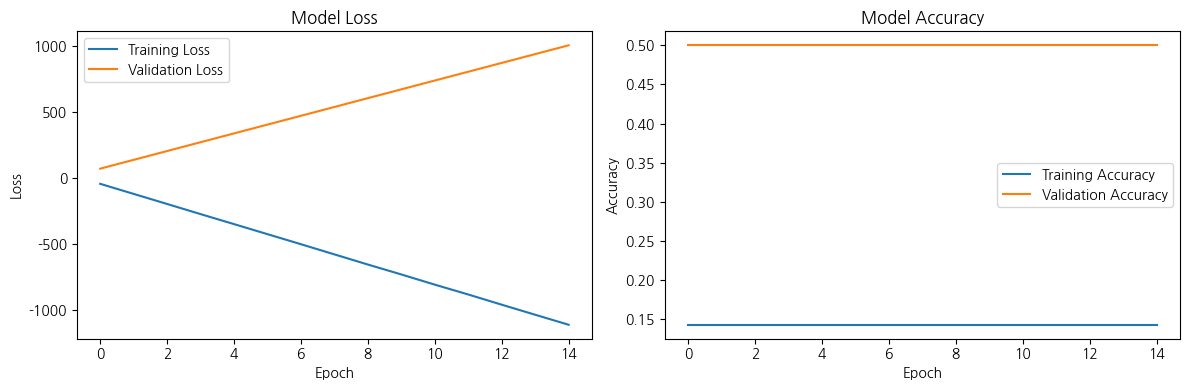

In [19]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
# 훈련 과정 그래프
plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 요약

이 노트북에서는 다음을 학습했습니다:

1. **사전학습된 Word2Vec 임베딩 활용**: Google News 데이터로 학습된 Word2Vec 모델 사용
2. **임베딩 매트릭스 생성**: 어휘사전과 사전학습된 임베딩 매핑
3. **고정된 임베딩 층**: `trainable=False`로 사전학습된 가중치 보존
4. **양방향 LSTM**: 텍스트의 양방향 컨텍스트 활용
5. **성능 개선**: 사전학습된 임베딩을 통한 일반화 성능 향상

### 주요 장점
- 적은 데이터로도 좋은 성능 달성 가능
- 사전학습된 단어 표현으로 의미적 유사성 활용
- 훈련 시간 단축 (임베딩 층 고정)

### 다음 단계
- 다른 사전학습된 임베딩 (GloVe, FastText) 비교
- Fine-tuning (`trainable=True`) 실험
- Transformer 기반 모델 (BERT, GPT) 활용